### **Import Libraries**


In [ ]:
pip install bertopic

In [ ]:
pip install -U scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 32.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [ ]:
import sklearn as sl

In [ ]:
import numpy as np
import pandas as pd
from copy import deepcopy
from bertopic import BERTopic


In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import re
from wordcloud import WordCloud

### **Load the Dataset**

In [ ]:
df = pd.read_csv("medium_data updated.csv")

In [ ]:
df.head()

id                                                url  \
0   1  https://towardsdatascience.com/a-beginners-gui...   
1   2  https://towardsdatascience.com/hands-on-graph-...   
2   3  https://towardsdatascience.com/how-to-use-ggpl...   
3   4  https://towardsdatascience.com/databricks-how-...   
4   5  https://towardsdatascience.com/a-step-by-step-...   

                                               title  \
0  A Beginner’s Guide to Word Embedding with Gens...   
1  Hands-on Graph Neural Networks with PyTorch & ...   
2                       How to Use ggplot2 in Python   
3  Databricks: How to Save Files in CSV on Your L...   
4  A Step-by-Step Implementation of Gradient Desc...   

                                  subtitle   image  claps responses  \
0                                      NaN   1.png    850         8   
1                                      NaN   2.png   1100        11   
2         A Grammar of Graphics for Python   3.png    767         1   
3  When I work on Python projects dealing…  4.jpeg    354         0   
4          One example of building neural…  5.jpeg    211         3   

   reading_time           publication       date  
0             8  Towards Data Science  5/30/2019  
1             9  Towards Data Science  5/30/2019  
2             5  Towards Data Science  5/30/2019  
3             4  Towards Data Science  5/30/2019  
4             4  Towards Data Science  5/30/2019

Let's look at the article distribution of this dataset based on their publication


<Axes: xlabel='publication', ylabel='count'>

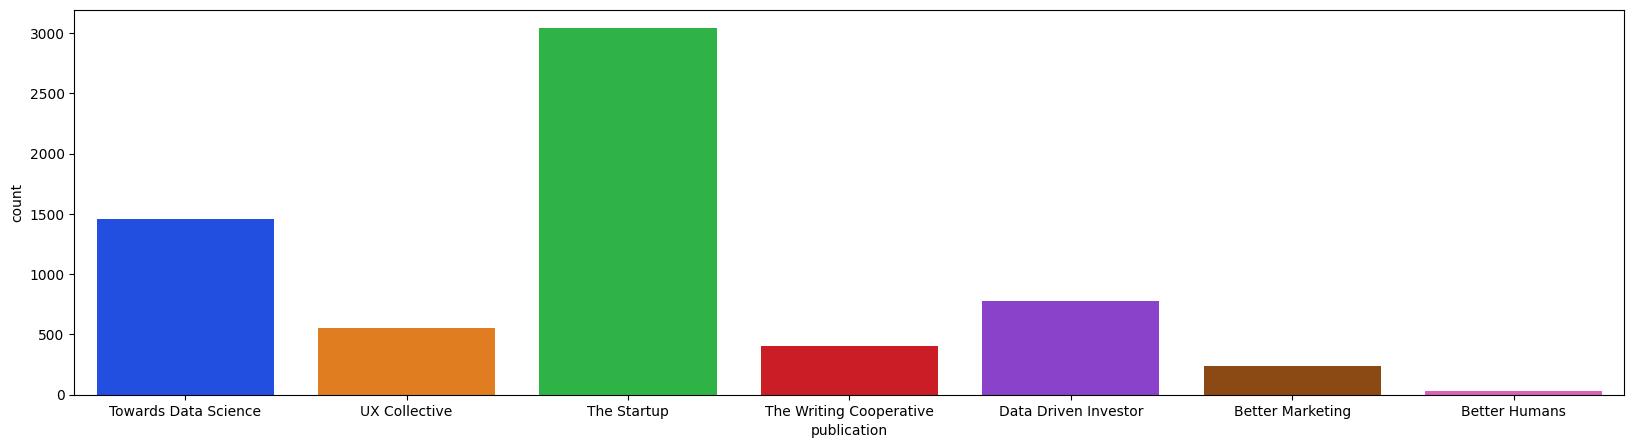

In [ ]:
plt.figure(figsize=(20,5))
sns.countplot(x="publication", data=df, palette="bright")

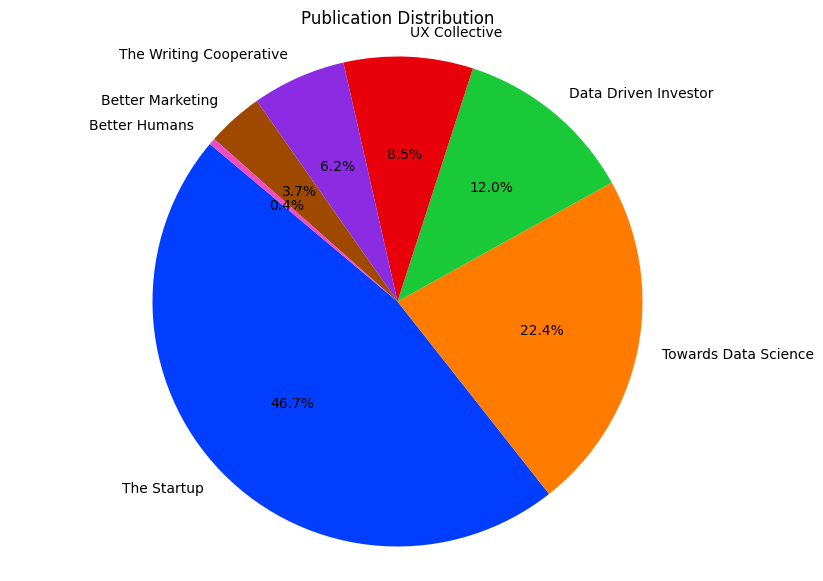

In [ ]:
# Sample data
data = df['publication'].value_counts()
labels = data.index
sizes = data.values

# Calculate percentages
percentages = 100 * sizes / sizes.sum()

# Define Seaborn color palette
colors = sns.color_palette('bright')[0:len(labels)]

# Create pie chart
plt.figure(figsize=(10, 7))
plt.pie(percentages, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Publication Distribution')
plt.show()

Count of the publications

In [ ]:
counts = df['publication'].value_counts()
print(counts)

publication
The Startup                3041
Towards Data Science       1461
Data Driven Investor        778
UX Collective               555
The Writing Cooperative     403
Better Marketing            242
Better Humans                28
Name: count, dtype: int64


# **Data Preprocessing**

Since the text we are working with may contain capital letters, numbers, contractions, HTML formats, and punctuation, the initial data preprocessing steps need to be performed to clean the dataframe before proceeding with further analysis.

**Check for Null values**

In [ ]:
#checking the null value count in the dataframe
null_values = df.isnull().sum()
print(null_values)

id                 0
url                0
title              0
subtitle        3029
image            147
claps              0
responses          0
reading_time       0
publication        0
date               0
dtype: int64


 We observe that the "subtitle" column contains the highest number of null values. However, despite these null values, we cannot discard the non-null entries, as our primary focus is the "title" column, which contains no missing values. Therefore, we will retain the "subtitle" column and utilize the available entries as supplementary information, considering only the cells with valid data.

**Coverting the title and subtitle columns to lists**

In [ ]:

#Convert title to a list
docs_title =  list(df.loc[:,"title"].values)

#Convert subtitle to a list
docs_subtitle = list(df.loc[:,"subtitle"].values)

#combine both lists together
docs_combined = list((df["title"] + ' ' + df["subtitle"].fillna('')).values)

**docs_combined is the corpus of this database, now will apply the essential NLP data preprocessing steps**

# 1. Lowercasing

This step will convert all the test to lowercase letters to ensure the uniformity.

In [ ]:
docs = [doc.lower() for doc in docs_combined]


In [ ]:
print(docs[4])

a step-by-step implementation of gradient descent and backpropagation one example of building neural…


# 2. Tokenization

This will breakdown the text into smaller units called "takens" (words or sentences). This helps in analyzing the text at a granular level.

In [ ]:
from nltk.tokenize import word_tokenize

# Download the punkt tokenizer models
nltk.download('punkt')

# Tokenize the text
tokens=[word_tokenize(doc) for doc in docs]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**What is "punkt"?**

“Punkt” is a pre-trained model for tokenizing text into sentences and words. It is a part of the NLTK data package and is essential for functions like word_tokenize to work correctly. Tokenization is the process of splitting text into smaller units, such as words or sentences.

In [ ]:
# Display the first 10 tokens
print(tokens[:10])

[['a', 'beginner', '’', 's', 'guide', 'to', 'word', 'embedding', 'with', 'gensim', 'word2vec', 'model'], ['hands-on', 'graph', 'neural', 'networks', 'with', 'pytorch', '&', 'pytorch', 'geometric'], ['how', 'to', 'use', 'ggplot2', 'in', 'python', 'a', 'grammar', 'of', 'graphics', 'for', 'python'], ['databricks', ':', 'how', 'to', 'save', 'files', 'in', 'csv', 'on', 'your', 'local', 'computer', 'when', 'i', 'work', 'on', 'python', 'projects', 'dealing…'], ['a', 'step-by-step', 'implementation', 'of', 'gradient', 'descent', 'and', 'backpropagation', 'one', 'example', 'of', 'building', 'neural…'], ['an', 'easy', 'introduction', 'to', 'sql', 'for', 'data', 'scientists'], ['hypothesis', 'testing', 'visualized', 'literally', 'seeing', 'how', 'stat', 'tests', 'work'], ['introduction', 'to', 'latent', 'matrix', 'factorization', 'recommender', 'systems'], ['which', '2020', 'candidate', 'is', 'the', 'best', 'at', 'twitter', '?', 'a', 'data', 'analysis', 'of', 'the', '2020', 'democratic', 'candida

# 3. Removing Punctuations

This will clean the corpus by removing all the punctuations marks.

In [ ]:
# Create a translation table that maps each punctuation character to None
translator = str.maketrans('', '', string.punctuation)

# Remove punctuation from each document in the corpus
docs = [doc.translate(translator) for doc in docs]

In [ ]:
# Display the docs without punctuations
print(docs[:10])

['a beginner’s guide to word embedding with gensim word2vec\xa0model ', 'handson graph neural networks with pytorch  pytorch geometric ', 'how to use ggplot2 in\xa0python a grammar of graphics for\xa0python', 'databricks how to save files in csv on your local\xa0computer when i work on python projects\xa0dealing…', 'a stepbystep implementation of gradient descent and backpropagation one example of building\xa0neural…', 'an easy introduction to sql for data scientists ', 'hypothesis testing visualized literally seeing how stat tests\xa0work', 'introduction to latent matrix factorization recommender systems ', 'which 2020 candidate is the best at\xa0twitter a data analysis of the 2020 democratic candidate twitter\xa0accounts', 'what if ai model understanding were\xa0easy see  analyticsforai in action in this whatif\xa0tool…']


# 4. Removing Stopwords

This remove common words that do not contribute much to the meaning of the text.

(eg: 'the', 'is')

In [ ]:
# Import the stopword module from NLTK toolkit
nltk.download('stopwords')
from nltk.corpus import stopwords

# Create a set of English stopwords and covert the list into a set for faster lookup
stop_words = set(stopwords.words('english'))

# Remove stopwords from each document in the corpus
tokens = [[word for word in doc if word not in stop_words] for doc in tokens]

# Display the docs without punctuations
print(docs[:10])

['a beginner’s guide to word embedding with gensim word2vec\xa0model ', 'handson graph neural networks with pytorch  pytorch geometric ', 'how to use ggplot2 in\xa0python a grammar of graphics for\xa0python', 'databricks how to save files in csv on your local\xa0computer when i work on python projects\xa0dealing…', 'a stepbystep implementation of gradient descent and backpropagation one example of building\xa0neural…', 'an easy introduction to sql for data scientists ', 'hypothesis testing visualized literally seeing how stat tests\xa0work', 'introduction to latent matrix factorization recommender systems ', 'which 2020 candidate is the best at\xa0twitter a data analysis of the 2020 democratic candidate twitter\xa0accounts', 'what if ai model understanding were\xa0easy see  analyticsforai in action in this whatif\xa0tool…']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 5. Stemming

This is the process of reducing a word to base form often by chopping off 'affixes' like 'suffixes' or 'prefixes'

In [ ]:
#import PoterStemmer module from NLTK library
from nltk.stem import PorterStemmer

# Initialize the Porter Stemmer
stemmer = PorterStemmer()

# Apply stemming to each word in each document
stemmed_tokens = [[stemmer.stem(word) for word in doc] for doc in tokens]

# Display the stemmed tokens
print(stemmed_tokens[:10])


[['beginn', '’', 'guid', 'word', 'embed', 'gensim', 'word2vec', 'model'], ['hands-on', 'graph', 'neural', 'network', 'pytorch', '&', 'pytorch', 'geometr'], ['use', 'ggplot2', 'python', 'grammar', 'graphic', 'python'], ['databrick', ':', 'save', 'file', 'csv', 'local', 'comput', 'work', 'python', 'project', 'dealing…'], ['step-by-step', 'implement', 'gradient', 'descent', 'backpropag', 'one', 'exampl', 'build', 'neural…'], ['easi', 'introduct', 'sql', 'data', 'scientist'], ['hypothesi', 'test', 'visual', 'liter', 'see', 'stat', 'test', 'work'], ['introduct', 'latent', 'matrix', 'factor', 'recommend', 'system'], ['2020', 'candid', 'best', 'twitter', '?', 'data', 'analysi', '2020', 'democrat', 'candid', 'twitter', 'account'], ['ai', 'model', 'understand', 'easi', '?', 'see', 'analytics-for-ai', 'action', 'what-if', 'tool…']]


# 6. Lemmatization

This is similar to Stemming but it reduce word into their lemma, which is the canonical or dictionary form of the word.

In [ ]:
# Download the wordnet data which is necessary to WordNetLemmatizer function
nltk.download('wordnet')

# Import the WordNetLemmatizer module from nltk library
from nltk.stem import WordNetLemmatizer

# Create an Instance of the WordNetLemmatizer class, which will be used to apply lemmatization to words
lemmatizer = WordNetLemmatizer()

# Apply lemmatization to each word in each document in the stemed_token List.
lemmatised_tokens = [[lemmatizer.lemmatize(word) for word in doc] for doc in stemmed_tokens]

# Display the lemmatized tokens
print(lemmatised_tokens[:10])

[nltk_data] Downloading package wordnet to /root/nltk_data...


[['beginn', '’', 'guid', 'word', 'embed', 'gensim', 'word2vec', 'model'], ['hands-on', 'graph', 'neural', 'network', 'pytorch', '&', 'pytorch', 'geometr'], ['use', 'ggplot2', 'python', 'grammar', 'graphic', 'python'], ['databrick', ':', 'save', 'file', 'csv', 'local', 'comput', 'work', 'python', 'project', 'dealing…'], ['step-by-step', 'implement', 'gradient', 'descent', 'backpropag', 'one', 'exampl', 'build', 'neural…'], ['easi', 'introduct', 'sql', 'data', 'scientist'], ['hypothesi', 'test', 'visual', 'liter', 'see', 'stat', 'test', 'work'], ['introduct', 'latent', 'matrix', 'factor', 'recommend', 'system'], ['2020', 'candid', 'best', 'twitter', '?', 'data', 'analysi', '2020', 'democrat', 'candid', 'twitter', 'account'], ['ai', 'model', 'understand', 'easi', '?', 'see', 'analytics-for-ai', 'action', 'what-if', 'tool…']]


# 7. Replace & Lemmatized Tokens


In [ ]:
lemmatised_tokens = [[word.replace("&", "and") for word in doc] for doc in lemmatised_tokens]

# Display the lemmatized tokens
print(lemmatised_tokens[10:20])

[['learn', '(', 'two-tim', ')', 'kaggl', 'grandmast', 'abhishek', 'thakur', 'draw', 'insight', 'abhishek…'], ['make', 'dota2', 'bot', 'use', 'ml', 'problem'], ['build', '‘', 'serverless', '’', 'chrome', 'extens'], ['teach', 'code', 'guid', 'problem', 'solut', 'teach', 'program'], ['reinvent', 'person', 'custom', 'experi', '?', '?', '?'], ['autom', 'hyperparamet', 'optim', 'beginn', '’', 'guid', 'use', 'bayesian', 'optim', 'with…'], ['idea', ':', 'design', 'methodolog', 'data', 'sprint'], ['robosomm', 'chapter', '3', ':', 'wine', 'embed', 'wine', 'recommend', 'one', 'cornerston', 'previous…'], ['data', 'scienc', 'interview', 'question', 'relev', 'read', '.'], ['faster', 'train', 'effici', 'cnn']]


**Replace "em class="markup--em markup--h3-em"" with " "**

In [ ]:
lemmatised_tokens = [[word.replace("em", "") for word in doc] for doc in lemmatised_tokens]

# Display the lemmatized tokens
print(lemmatised_tokens[10:20])

[['learn', '(', 'two-tim', ')', 'kaggl', 'grandmast', 'abhishek', 'thakur', 'draw', 'insight', 'abhishek…'], ['make', 'dota2', 'bot', 'use', 'ml', 'probl'], ['build', '‘', 'serverless', '’', 'chrome', 'extens'], ['teach', 'code', 'guid', 'probl', 'solut', 'teach', 'program'], ['reinvent', 'person', 'custom', 'experi', '?', '?', '?'], ['autom', 'hyperparamet', 'optim', 'beginn', '’', 'guid', 'use', 'bayesian', 'optim', 'with…'], ['idea', ':', 'design', 'methodolog', 'data', 'sprint'], ['robosomm', 'chapter', '3', ':', 'wine', 'bed', 'wine', 'recommend', 'one', 'cornerston', 'previous…'], ['data', 'scienc', 'interview', 'question', 'relev', 'read', '.'], ['faster', 'train', 'effici', 'cnn']]


In [ ]:
lemmatised_tokens = [[word.replace("h3-", "") for word in doc] for doc in lemmatised_tokens]

# Display the lemmatized tokens
print(lemmatised_tokens[10:20])

[['learn', '(', 'two-tim', ')', 'kaggl', 'grandmast', 'abhishek', 'thakur', 'draw', 'insight', 'abhishek…'], ['make', 'dota2', 'bot', 'use', 'ml', 'probl'], ['build', '‘', 'serverless', '’', 'chrome', 'extens'], ['teach', 'code', 'guid', 'probl', 'solut', 'teach', 'program'], ['reinvent', 'person', 'custom', 'experi', '?', '?', '?'], ['autom', 'hyperparamet', 'optim', 'beginn', '’', 'guid', 'use', 'bayesian', 'optim', 'with…'], ['idea', ':', 'design', 'methodolog', 'data', 'sprint'], ['robosomm', 'chapter', '3', ':', 'wine', 'bed', 'wine', 'recommend', 'one', 'cornerston', 'previous…'], ['data', 'scienc', 'interview', 'question', 'relev', 'read', '.'], ['faster', 'train', 'effici', 'cnn']]


In [ ]:
lemmatised_tokens = [[word.replace("class=", "") for word in doc] for doc in lemmatised_tokens]

# Display the lemmatized tokens
print(lemmatised_tokens[10:20])

[['learn', '(', 'two-tim', ')', 'kaggl', 'grandmast', 'abhishek', 'thakur', 'draw', 'insight', 'abhishek…'], ['make', 'dota2', 'bot', 'use', 'ml', 'probl'], ['build', '‘', 'serverless', '’', 'chrome', 'extens'], ['teach', 'code', 'guid', 'probl', 'solut', 'teach', 'program'], ['reinvent', 'person', 'custom', 'experi', '?', '?', '?'], ['autom', 'hyperparamet', 'optim', 'beginn', '’', 'guid', 'use', 'bayesian', 'optim', 'with…'], ['idea', ':', 'design', 'methodolog', 'data', 'sprint'], ['robosomm', 'chapter', '3', ':', 'wine', 'bed', 'wine', 'recommend', 'one', 'cornerston', 'previous…'], ['data', 'scienc', 'interview', 'question', 'relev', 'read', '.'], ['faster', 'train', 'effici', 'cnn']]


In [ ]:
lemmatised_tokens = [[word.replace("--", "") for word in doc] for doc in lemmatised_tokens]

# Display the lemmatized tokens
print(lemmatised_tokens[10:20])

[['learn', '(', 'two-tim', ')', 'kaggl', 'grandmast', 'abhishek', 'thakur', 'draw', 'insight', 'abhishek…'], ['make', 'dota2', 'bot', 'use', 'ml', 'probl'], ['build', '‘', 'serverless', '’', 'chrome', 'extens'], ['teach', 'code', 'guid', 'probl', 'solut', 'teach', 'program'], ['reinvent', 'person', 'custom', 'experi', '?', '?', '?'], ['autom', 'hyperparamet', 'optim', 'beginn', '’', 'guid', 'use', 'bayesian', 'optim', 'with…'], ['idea', ':', 'design', 'methodolog', 'data', 'sprint'], ['robosomm', 'chapter', '3', ':', 'wine', 'bed', 'wine', 'recommend', 'one', 'cornerston', 'previous…'], ['data', 'scienc', 'interview', 'question', 'relev', 'read', '.'], ['faster', 'train', 'effici', 'cnn']]


In [ ]:
lemmatised_tokens = [[word.replace("<", "") for word in doc] for doc in lemmatised_tokens]

# Display the lemmatized tokens
print(lemmatised_tokens[10:20])

[['learn', '(', 'two-tim', ')', 'kaggl', 'grandmast', 'abhishek', 'thakur', 'draw', 'insight', 'abhishek…'], ['make', 'dota2', 'bot', 'use', 'ml', 'probl'], ['build', '‘', 'serverless', '’', 'chrome', 'extens'], ['teach', 'code', 'guid', 'probl', 'solut', 'teach', 'program'], ['reinvent', 'person', 'custom', 'experi', '?', '?', '?'], ['autom', 'hyperparamet', 'optim', 'beginn', '’', 'guid', 'use', 'bayesian', 'optim', 'with…'], ['idea', ':', 'design', 'methodolog', 'data', 'sprint'], ['robosomm', 'chapter', '3', ':', 'wine', 'bed', 'wine', 'recommend', 'one', 'cornerston', 'previous…'], ['data', 'scienc', 'interview', 'question', 'relev', 'read', '.'], ['faster', 'train', 'effici', 'cnn']]


In [ ]:
lemmatised_tokens = [[word.replace(">", "") for word in doc] for doc in lemmatised_tokens]

# Display the lemmatized tokens
print(lemmatised_tokens[10:20])

[['learn', '(', 'two-tim', ')', 'kaggl', 'grandmast', 'abhishek', 'thakur', 'draw', 'insight', 'abhishek…'], ['make', 'dota2', 'bot', 'use', 'ml', 'probl'], ['build', '‘', 'serverless', '’', 'chrome', 'extens'], ['teach', 'code', 'guid', 'probl', 'solut', 'teach', 'program'], ['reinvent', 'person', 'custom', 'experi', '?', '?', '?'], ['autom', 'hyperparamet', 'optim', 'beginn', '’', 'guid', 'use', 'bayesian', 'optim', 'with…'], ['idea', ':', 'design', 'methodolog', 'data', 'sprint'], ['robosomm', 'chapter', '3', ':', 'wine', 'bed', 'wine', 'recommend', 'one', 'cornerston', 'previous…'], ['data', 'scienc', 'interview', 'question', 'relev', 'read', '.'], ['faster', 'train', 'effici', 'cnn']]


In [ ]:
lemmatised_tokens = [[word.replace("''", "") for word in doc] for doc in lemmatised_tokens]

# Display the lemmatized tokens
print(lemmatised_tokens[10:20])

[['learn', '(', 'two-tim', ')', 'kaggl', 'grandmast', 'abhishek', 'thakur', 'draw', 'insight', 'abhishek…'], ['make', 'dota2', 'bot', 'use', 'ml', 'probl'], ['build', '‘', 'serverless', '’', 'chrome', 'extens'], ['teach', 'code', 'guid', 'probl', 'solut', 'teach', 'program'], ['reinvent', 'person', 'custom', 'experi', '?', '?', '?'], ['autom', 'hyperparamet', 'optim', 'beginn', '’', 'guid', 'use', 'bayesian', 'optim', 'with…'], ['idea', ':', 'design', 'methodolog', 'data', 'sprint'], ['robosomm', 'chapter', '3', ':', 'wine', 'bed', 'wine', 'recommend', 'one', 'cornerston', 'previous…'], ['data', 'scienc', 'interview', 'question', 'relev', 'read', '.'], ['faster', 'train', 'effici', 'cnn']]


In [ ]:
lemmatised_tokens = [[word.replace("/", "") for word in doc] for doc in lemmatised_tokens]

# Display the lemmatized tokens
print(lemmatised_tokens[10:20])

[['learn', '(', 'two-tim', ')', 'kaggl', 'grandmast', 'abhishek', 'thakur', 'draw', 'insight', 'abhishek…'], ['make', 'dota2', 'bot', 'use', 'ml', 'probl'], ['build', '‘', 'serverless', '’', 'chrome', 'extens'], ['teach', 'code', 'guid', 'probl', 'solut', 'teach', 'program'], ['reinvent', 'person', 'custom', 'experi', '?', '?', '?'], ['autom', 'hyperparamet', 'optim', 'beginn', '’', 'guid', 'use', 'bayesian', 'optim', 'with…'], ['idea', ':', 'design', 'methodolog', 'data', 'sprint'], ['robosomm', 'chapter', '3', ':', 'wine', 'bed', 'wine', 'recommend', 'one', 'cornerston', 'previous…'], ['data', 'scienc', 'interview', 'question', 'relev', 'read', '.'], ['faster', 'train', 'effici', 'cnn']]


In [ ]:
lemmatised_tokens = [[word.replace("markup", "") for word in doc] for doc in lemmatised_tokens]

# Display the lemmatized tokens
print(lemmatised_tokens[:10])

[['beginn', '’', 'guid', 'word', 'bed', 'gensim', 'word2vec', 'model'], ['hands-on', 'graph', 'neural', 'network', 'pytorch', 'and', 'pytorch', 'geometr'], ['use', 'ggplot2', 'python', 'grammar', 'graphic', 'python'], ['databrick', ':', 'save', 'file', 'csv', 'local', 'comput', 'work', 'python', 'project', 'dealing…'], ['step-by-step', 'implent', 'gradient', 'descent', 'backpropag', 'one', 'exampl', 'build', 'neural…'], ['easi', 'introduct', 'sql', 'data', 'scientist'], ['hypothesi', 'test', 'visual', 'liter', 'see', 'stat', 'test', 'work'], ['introduct', 'latent', 'matrix', 'factor', 'recommend', 'syst'], ['2020', 'candid', 'best', 'twitter', '?', 'data', 'analysi', '2020', 'docrat', 'candid', 'twitter', 'account'], ['ai', 'model', 'understand', 'easi', '?', 'see', 'analytics-for-ai', 'action', 'what-if', 'tool…']]


# 8. Removing Numbers

This will remove the Numerical values from the corpus

In [ ]:
lemmatised_tokens = [[word for word in doc if not word.isdigit()] for doc in lemmatised_tokens]

# Display the lemmatized tokens
print(lemmatised_tokens[:10])

[['beginn', '’', 'guid', 'word', 'bed', 'gensim', 'word2vec', 'model'], ['hands-on', 'graph', 'neural', 'network', 'pytorch', 'and', 'pytorch', 'geometr'], ['use', 'ggplot2', 'python', 'grammar', 'graphic', 'python'], ['databrick', ':', 'save', 'file', 'csv', 'local', 'comput', 'work', 'python', 'project', 'dealing…'], ['step-by-step', 'implent', 'gradient', 'descent', 'backpropag', 'one', 'exampl', 'build', 'neural…'], ['easi', 'introduct', 'sql', 'data', 'scientist'], ['hypothesi', 'test', 'visual', 'liter', 'see', 'stat', 'test', 'work'], ['introduct', 'latent', 'matrix', 'factor', 'recommend', 'syst'], ['candid', 'best', 'twitter', '?', 'data', 'analysi', 'docrat', 'candid', 'twitter', 'account'], ['ai', 'model', 'understand', 'easi', '?', 'see', 'analytics-for-ai', 'action', 'what-if', 'tool…']]


# 9. Handling Contractions

This expand to words to their full form

Eg: don't ---> do not



In [ ]:
pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 9.0 MB/s eta 0:00:00


In [ ]:
# Import contraction Library
import contractions

docs = [contractions.fix(doc) for doc in docs]



# 10. Spell Checking

This use to correct spelling errors in the text

In [ ]:
pip install pyspellchecker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 36.4 MB/s eta 0:00:00


In [ ]:
#from spellchecker import SpellChecker

# Create an instance of the SpellChecker class
#spell = SpellChecker()

# Iterate through each document in the corpus
#lemmatised_tokens = [[spell.correction(word) for word in doc] for doc in lemmatised_tokens]

# Display the lemmatized tokens
#print(lemmatised_tokens[:10])

**Spell checking in "docs" corpus instead of "lemmatised_tokens"**

In [ ]:
#from spellchecker import SpellChecker

# Create an instance of the SpellChecker class
#spell = SpellChecker()

# Assuming 'docs' is a list of documents, where each document is a list of words
# Apply spell correction to each word in each document
#corrected_docs = [[spell.correction(word) for word in doc] for doc in docs]

# Display the corrected documents
#print(corrected_docs[:10])

# 11. Removing URLs and HTML tags

In [ ]:
#docs=re.sub(r'http\S+', '', str(docs))
#docs=re.sub(r'<.*?>', '', str(docs))

Title column data as a List - this step not required since doc_combined is there.

In [ ]:

#docs = list(df.loc[:,"title"].values)

In [ ]:
#docs[:5]

**Displaying the Top articles based on claps**

In [ ]:
top20_articles = df.sort_values(["claps"],ascending=0)[0:20][["title","claps","publication","reading_time", "url","subtitle"]]
top20_articles.reset_index(drop=True, inplace=True)
top20_articles

title  claps  \
0   I Have 15 ideas To Change Your Life. Do you Ha...  38000   
1   How To Handle Other People’s Bad Moods Like a Pro  23000   
2   " "If You Learn to Write, You Can Change Your ...  20000   
3                How To Break A Negative Thought Loop  16400   
4   10 Things To Do When Medium Doesn’t Curate You...  12600   
5          How To Retain More From The Books You Read  11700   
6   The Only 3 Types of Writing People Actually Wa...  11300   
7   " "To Be Well-Informed, Cut the News and Read ...  10800   
8             10 best Chrome extensions for designers  10500   
9   How to Write and Publish Articles that get Not...  10100   
10  How to Increase Your Motivation in 2 Minutes p...   9700   
11             How To Create a Passive Income Machine   9400   
12                          The McDonaldization of UX   9400   
13  Want a Happier, More Fulfilling Life? 75-Year ...   9100   
14  7 simple methods to get better at Visual/UI De...   8900   
15  How I Make Money on Airbnb Without Owning or R...   8700   
16                           UI cheat sheets: buttons   8100   
17  12 Things I Learned During My First Year as a ...   8000   
18  How to Manage Your Time and Learn New Things E...   7300   
19  " "Sell Something Bigger Than Your Otherwise B...   7000   

                publication  reading_time  \
0               The Startup             5   
1          Better Marketing             7   
2               The Startup             6   
3               The Startup             4   
4   The Writing Cooperative             5   
5               The Startup             5   
6               The Startup             5   
7          Better Marketing             4   
8             UX Collective             5   
9               The Startup            11   
10            Better Humans             5   
11         Better Marketing            10   
12            UX Collective             8   
13            Better Humans             9   
14            UX Collective             7   
15              The Startup             4   
16            UX Collective            13   
17     Towards Data Science            11   
18              The Startup             4   
19              The Startup             6   

                                                  url  \
0   https://medium.com/swlh/i-have-15-ideas-to-cha...   
1   https://medium.com/better-marketing/how-to-han...   
2   https://medium.com/swlh/if-you-learn-to-write-...   
3   https://medium.com/swlh/how-to-break-a-negativ...   
4   https://writingcooperative.com/10-things-to-do...   
5   https://medium.com/swlh/how-to-retain-more-fro...   
6   https://medium.com/swlh/the-only-3-types-of-wr...   
7   https://medium.com/better-marketing/to-be-well...   
8   https://uxdesign.cc/10-best-chrome-extensions-...   
9   https://medium.com/swlh/how-to-write-and-publi...   
10  https://medium.com/better-humans/how-to-do-a-l...   
11  https://medium.com/better-marketing/how-to-cre...   
12  https://uxdesign.cc/the-mcdonaldization-of-ux-...   
13  https://medium.com/better-humans/want-a-happie...   
14  https://uxdesign.cc/7-simple-methods-to-get-be...   
15  https://medium.com/swlh/how-i-make-money-on-ai...   
16  https://uxdesign.cc/ui-cheat-sheets-buttons-73...   
17  https://towardsdatascience.com/12-things-i-lea...   
18  https://medium.com/swlh/how-to-manage-your-tim...   
19  https://medium.com/swlh/how-to-sell-something-...   

                                             subtitle  
0                                                 NaN  
1   Step 1: Treat difficult emotions like a puzzle...  
2                          The secret is in the line.  
3   “It’s pretty black-and-white. You either let g...  
4           When I have a curation gap, I go into my…  
5        Making sure you get the most out of reading.  
6                                                 NaN  
7              More information isn’t the solution" "  
8   After months of testing, here are the 10 best ...  

In [ ]:
counts = top20_articles['publication'].value_counts()
print(counts)

publication
The Startup                9
UX Collective              4
Better Marketing           3
Better Humans              2
The Writing Cooperative    1
Towards Data Science       1
Name: count, dtype: int64


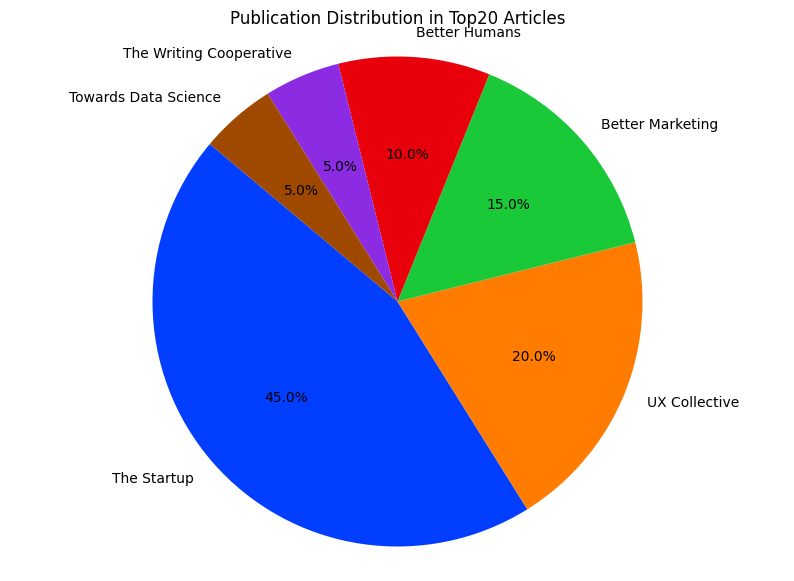

In [ ]:
# Assuming 'top20_articles' is your DataFrame
counts = top20_articles['publication'].value_counts()

# Calculate percentages
percentages = 100 * counts / counts.sum()

# Define Seaborn color palette
colors = sns.color_palette('bright')[0:len(counts)]

# Create pie chart
plt.figure(figsize=(10, 7))
plt.pie(percentages, labels=counts.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Publication Distribution in Top20 Articles')
plt.show()

Considering the total count of articles, 'The Startup' has the highest count therefore representing in the top20 article percentage also higher.

But when it comes to the probability relevant to the count, the highest achievement is in 'Better Humans' Publication.

**Average Claps for a Publication**

In [ ]:
# Average claps for different publications.
avg_by_publication = df.groupby(by="publication")[["claps"]].mean()
avg_by_publication.sort_values(["claps"],ascending=False)
# Medium bloggers should start to write articles in Better Humans if they want
# more reactions from readers.

claps
publication                         
Better Humans            1827.785714
Better Marketing          829.347107
UX Collective             380.924324
The Writing Cooperative   372.744417
The Startup               303.403815
Towards Data Science      283.631759
Data Driven Investor       95.034704

**Average Reading time for an article**

In [ ]:
avg_by_publication = df.groupby(by="publication")[["reading_time"]].mean()
avg_by_publication.sort_values(["reading_time"],ascending=False)

reading_time
publication                          
Better Humans               13.357143
Towards Data Science         7.276523
Better Marketing             6.409091
UX Collective                6.030631
The Startup                  5.906281
Data Driven Investor         5.219794
The Writing Cooperative      4.965261

**Now will check what kind of topics or words includes in top 20 articles**

# Word Cloud using docs corpus

Whole dataset representation in a word cloud

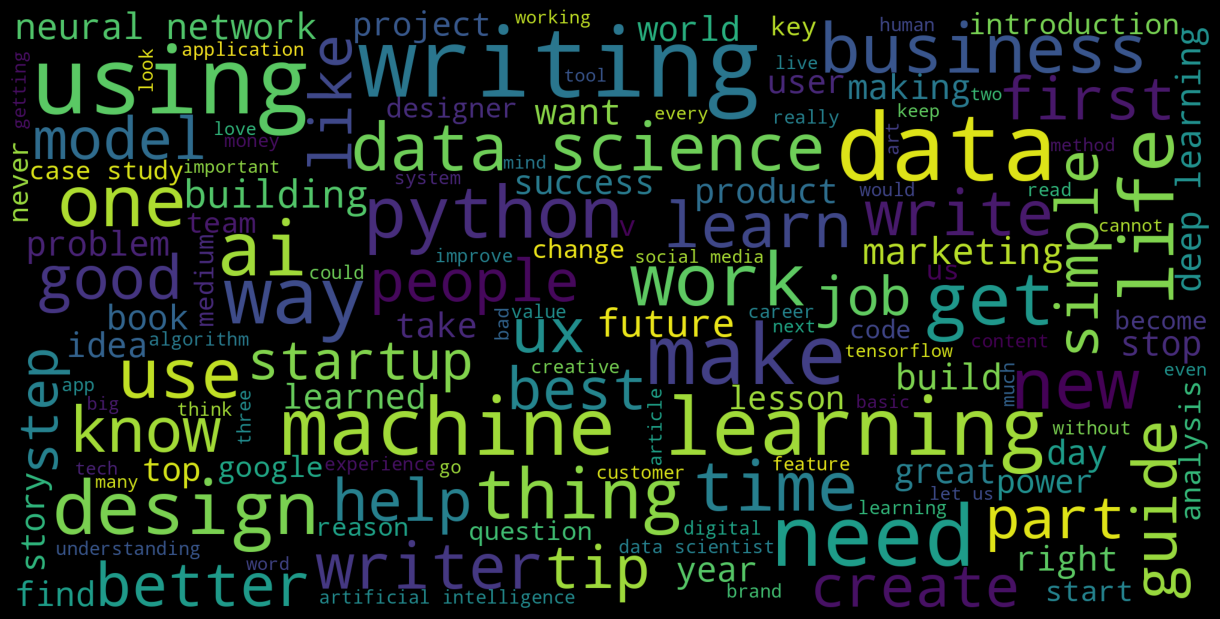

In [ ]:

docs1 = "".join(str(x) for x in docs)


stop_words = set(nltk.corpus.stopwords.words("english"))
word_cloud = WordCloud(stopwords=stop_words, width=2000, height=1000,\
                            max_font_size=160, min_font_size=30).generate(docs1)
plt.figure(figsize=(12,6), facecolor="k")
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


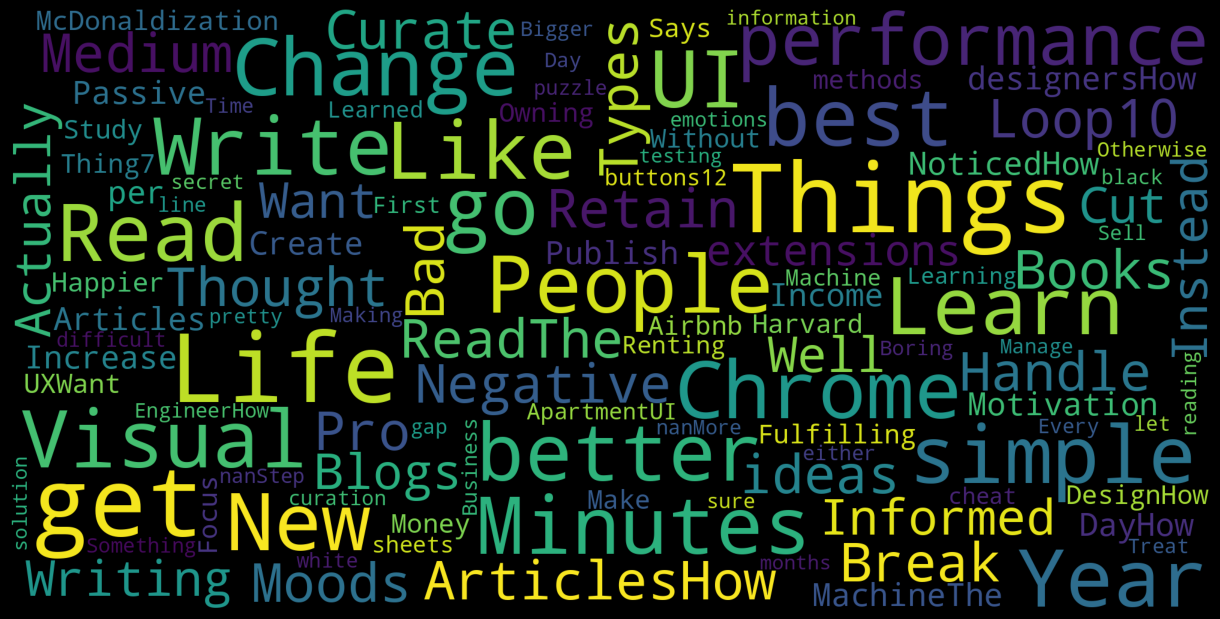

In [ ]:
#Firstly lets see the wordcloud for Top20 Articles.
nltk.download('stopwords')
title_data = "".join(str(x) for x in top20_articles["title"])
subtitle_data = "".join(str(x) for x in top20_articles["subtitle"])
title_data = title_data+subtitle_data
stop_words = set(nltk.corpus.stopwords.words("english"))
word_cloud = WordCloud(stopwords=stop_words, width=2000, height=1000,\
                            max_font_size=160, min_font_size=30).generate(title_data)
plt.figure(figsize=(12,6), facecolor="k")
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

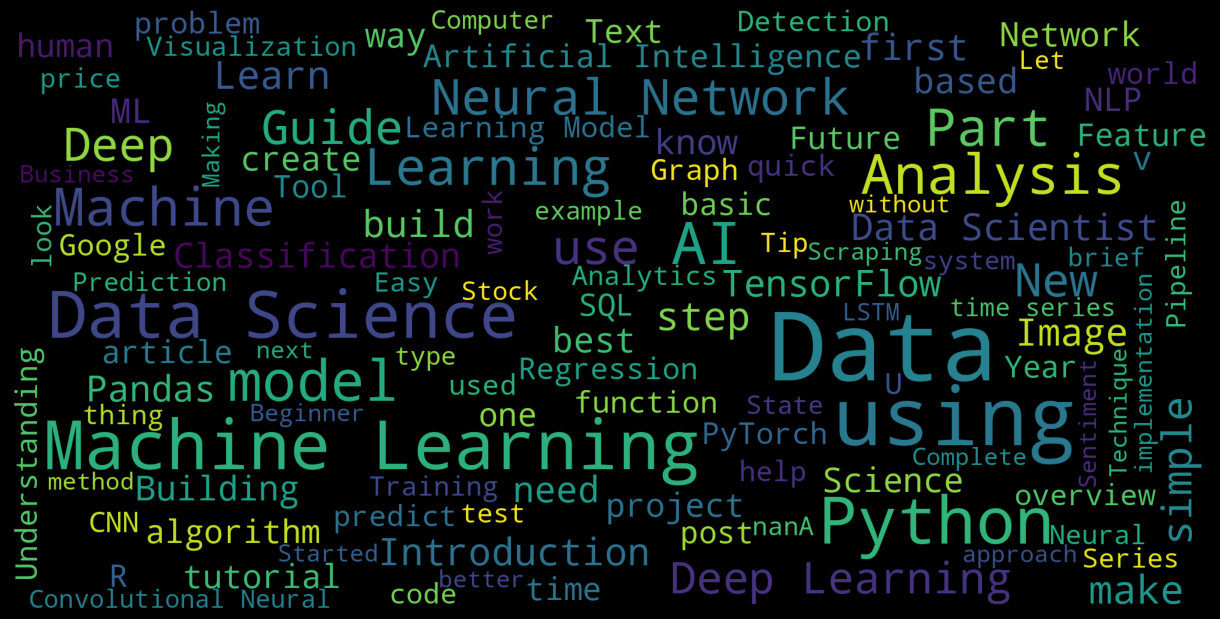

In [ ]:
#Firstly lets see the wordcloud for towards data science.

df_data_science = df[df["publication"]=="Towards Data Science"]
title_data = "".join(str(x) for x in df_data_science["title"])
subtitle_data = "".join(str(x) for x in df_data_science["subtitle"])
title_data = title_data+subtitle_data
stop_words = set(nltk.corpus.stopwords.words("english"))
word_cloud = WordCloud(stopwords=stop_words, width=2000, height=1000,\
                            max_font_size=160, min_font_size=30).generate(title_data)
plt.figure(figsize=(12,6), facecolor="k")
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show() #Aha, we saw a lot of familar topics.We should start to figure out these topics now!

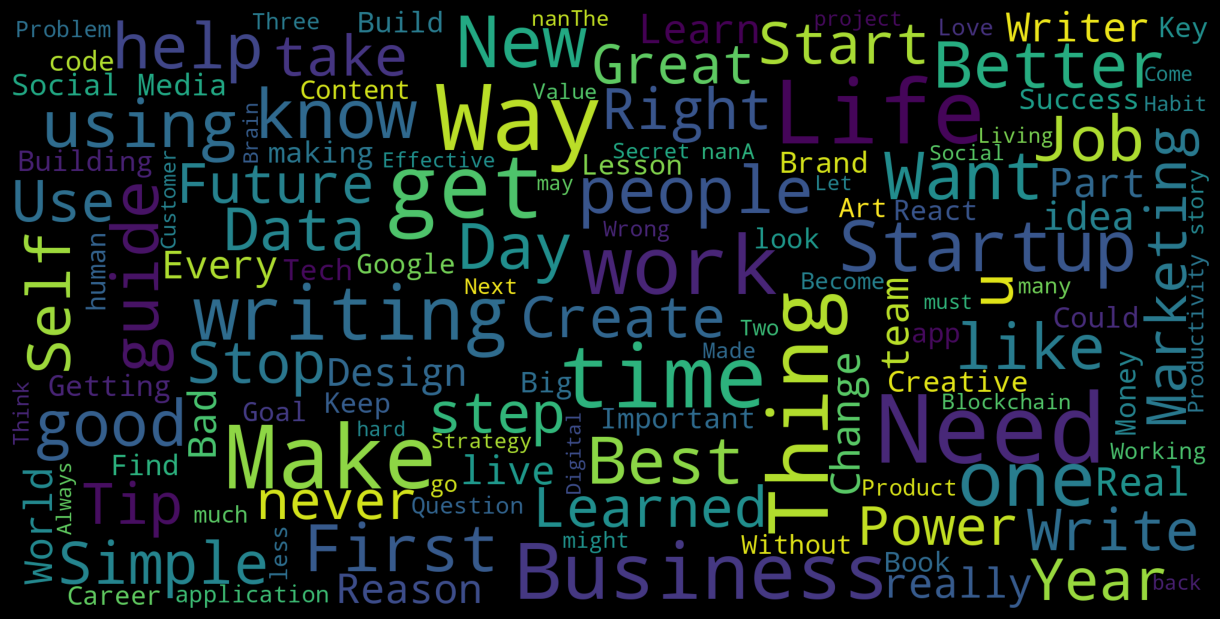

In [ ]:
# lets see the wordcloud for The Startup.

df_data_science = df[df["publication"]=="The Startup"]
title_data = "".join(str(x) for x in df_data_science["title"])
subtitle_data = "".join(str(x) for x in df_data_science["subtitle"])
title_data = title_data+subtitle_data
stop_words = set(nltk.corpus.stopwords.words("english"))
word_cloud = WordCloud(stopwords=stop_words, width=2000, height=1000,\
                            max_font_size=160, min_font_size=30).generate(title_data)
plt.figure(figsize=(12,6), facecolor="k")
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

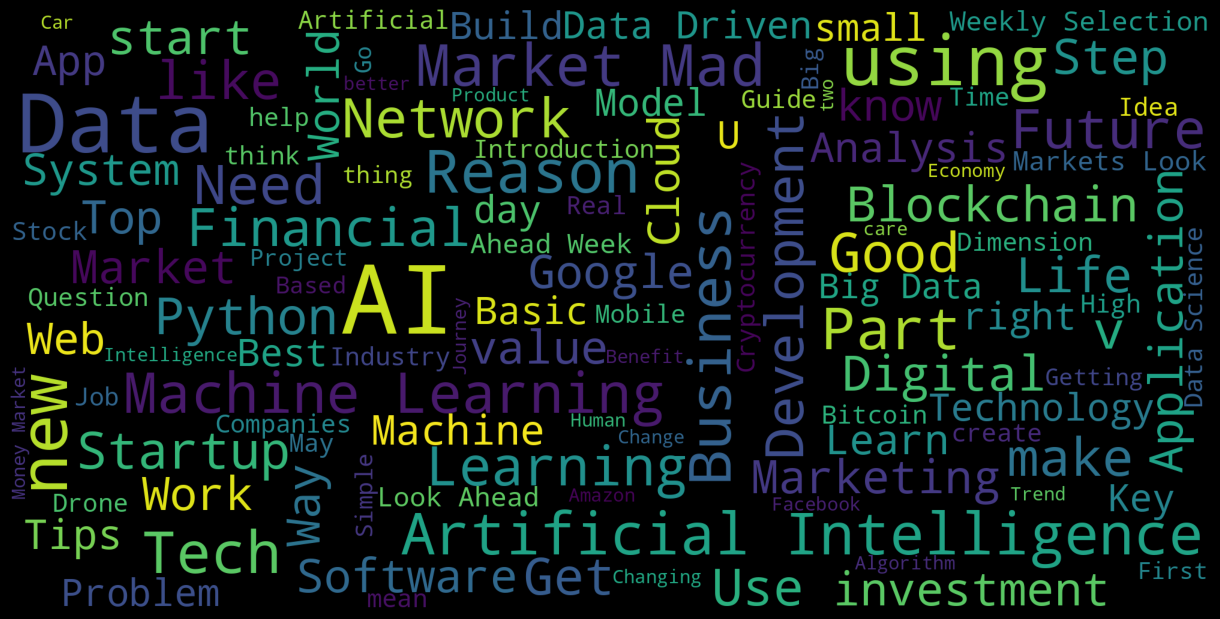

In [ ]:
# lets see the wordcloud for Data Driven Investor .

df_data_science = df[df["publication"]=="Data Driven Investor"]
title_data = "".join(str(x) for x in df_data_science["title"])
subtitle_data = "".join(str(x) for x in df_data_science["subtitle"])
title_data = title_data+subtitle_data
stop_words = set(nltk.corpus.stopwords.words("english"))
word_cloud = WordCloud(stopwords=stop_words, width=2000, height=1000,\
                            max_font_size=160, min_font_size=30).generate(title_data)
plt.figure(figsize=(12,6), facecolor="k")
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

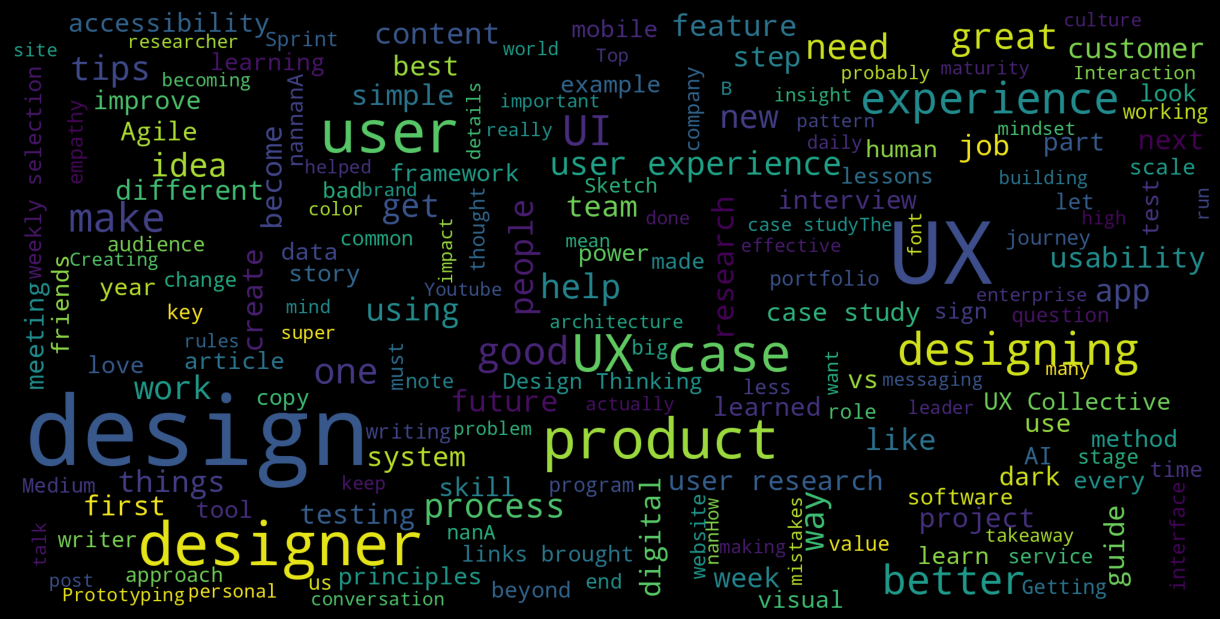

In [ ]:
# lets see the wordcloud for UX Collective .

df_data_science = df[df["publication"]=="UX Collective"]
title_data = "".join(str(x) for x in df_data_science["title"])
subtitle_data = "".join(str(x) for x in df_data_science["subtitle"])
title_data = title_data+subtitle_data
stop_words = set(nltk.corpus.stopwords.words("english"))
word_cloud = WordCloud(stopwords=stop_words, width=2000, height=1000,\
                            max_font_size=160, min_font_size=30).generate(title_data)
plt.figure(figsize=(12,6), facecolor="k")
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

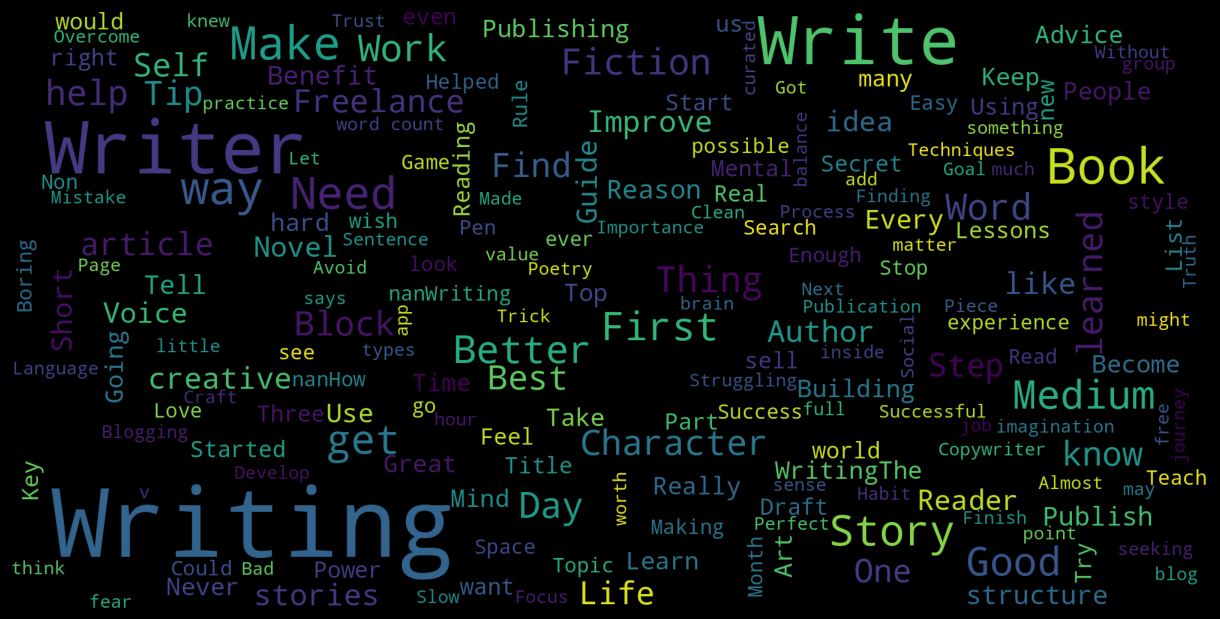

In [ ]:
 #lets see the wordcloud for The Writing Cooperative .

df_data_science = df[df["publication"]=="The Writing Cooperative"]
title_data = "".join(str(x) for x in df_data_science["title"])
subtitle_data = "".join(str(x) for x in df_data_science["subtitle"])
title_data = title_data+subtitle_data
stop_words = set(nltk.corpus.stopwords.words("english"))
word_cloud = WordCloud(stopwords=stop_words, width=2000, height=1000,\
                            max_font_size=160, min_font_size=30).generate(title_data)
plt.figure(figsize=(12,6), facecolor="k")
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

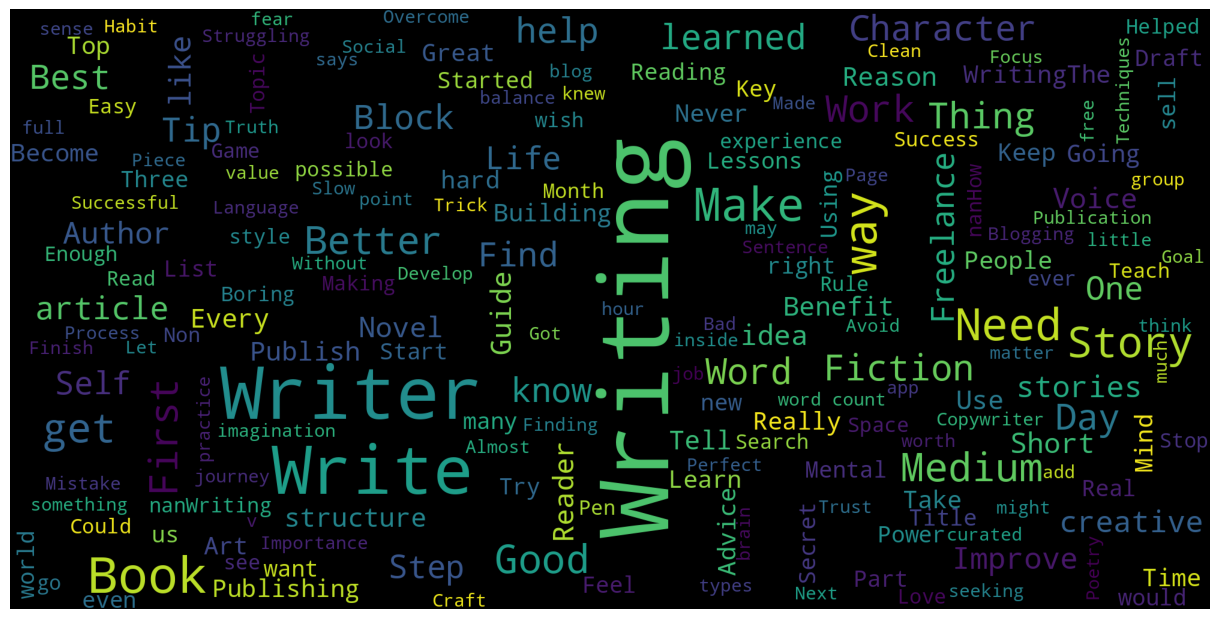

In [ ]:
 #lets see the wordcloud for The Writing Cooperative .

df_data_science = df[df["publication"]=="The Writing Cooperative"]
title_data = "".join(str(x) for x in df_data_science["title"])
subtitle_data = "".join(str(x) for x in df_data_science["subtitle"])
title_data = title_data+subtitle_data
stop_words = set(nltk.corpus.stopwords.words("english"))
word_cloud = WordCloud(stopwords=stop_words, width=2000, height=1000,\
                            max_font_size=160, min_font_size=30).generate(title_data)
plt.figure(figsize=(12,6), facecolor="w")
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### **Creating Topics**



In [ ]:
model = BERTopic(language='english')

In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
model_name = 'all-MiniLM-L6-v2'

In [ ]:
topics, probs = model.fit_transform(docs)

### **Check for Most Frequent Topics**

In [ ]:
model.get_topic_freq()

Topic  Count
1       -1   2221
23       0    542
8        1    234
14       2    212
19       3    186
..     ...    ...
5      104     11
108    105     11
31     106     10
92     107     10
7      108     10

[110 rows x 2 columns]

**To get the Top article topics in Bertopic modelling**

**Convert the title column in to list**

In [ ]:
#docs1 = list(top20_articles.loc[:,"title"].values)


In [ ]:
#Doc_top20 = top20_articles['title']+top20_articles['subtitle']
#Doc_top20 = Doc_top20.astype(str)
#topics, probs = model.fit_transform(Doc_top20)
#model.get_topic_freq()



The output Topic Count **0 -1 20** indicates that all 20 documents were assigned to the topic labeled -1. In BERTopic, the topic -1 is a special label used for outliers or documents that do not fit well into any of the identified topics.

**Possible Reasons for This Output:**

*   **Insufficient Data**: If the dataset is too small or lacks diversity, the model might not be able to identify distinct topics.
*   **Homogeneous Data**: If the documents are very similar to each other, the model might not find enough variation to create multiple topics.
*   **Preprocessing Issues**: If the text data is not properly preprocessed (e.g., contains a lot of noise, special characters, or irrelevant information), it can affect the model’s ability to identify topics.


### **Individual Topic Visualization**

In [ ]:
model.get_topic(3)

[('design', 0.07273203347397117),
 ('ux', 0.03975988839430784),
 ('designers', 0.03213410813186299),
 ('designer', 0.026767358045748143),
 ('designing', 0.018744896410253408),
 ('links', 0.018066938313534144),
 ('thinking', 0.014967828690531367),
 ('ui', 0.013711884697027292),
 ('thisweek', 0.013176222533976665),
 ('uxdesign', 0.013176222533976665)]

In [ ]:
model.get_topic(2)

[('machine', 0.07765074860250198),
 ('learning', 0.053991476542875894),
 ('machinelearning', 0.04809525918075959),
 ('model', 0.02372398140864887),
 ('ml', 0.020002099577595172),
 ('decision', 0.018511798711173054),
 ('classification', 0.018356750501193116),
 ('models', 0.017045554036822178),
 ('trees', 0.013333082326047815),
 ('recall', 0.013333082326047815)]

In [ ]:
model.get_topic(25)

[('job', 0.06250557986462978),
 ('career', 0.057660086247514154),
 ('jobs', 0.04000308359973602),
 ('promotion', 0.028687984513012715),
 ('pieces', 0.028687984513012715),
 ('advice', 0.027451975571361496),
 ('dreamjob', 0.023602056450316725),
 ('seekers', 0.023602056450316725),
 ('would', 0.022053326979109025),
 ('ghosting', 0.021946773402559763)]

### **Visualize Topics**

In [ ]:
model.visualize_topics()

### **Topic Reduction**


**Using "Auto" reduction method**

In [ ]:
#topic_model = BERTopic()
#topics, probs = topic_model.fit_transform(docs)

# Further reduce topics
#topic_model.reduce_topics(docs, nr_topics="auto")

# Access updated topics
#topics = topic_model.topics_

In [ ]:
#topic_model.get_topic_freq()

In [ ]:
#topic_model.visualize_topics()

In [ ]:

# Fit the BERTopic model
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(docs)

# Reduce the number of topics
topic_model = topic_model.reduce_topics(docs, nr_topics=30)

# Access updated topics
reduced_topics = topic_model.get_topics()
print(reduced_topics)

{-1: [('the', 0.026845611608019796), ('to', 0.02360949885093498), ('of', 0.020848868821433098), ('how', 0.019754751360640845), ('and', 0.019331158400850892), ('you', 0.016973674023143263), ('in', 0.016590809713230893), ('your', 0.016519150284464316), ('is', 0.016300172680005946), ('for', 0.014788542726121503)], 0: [('writing', 0.03166095288065744), ('to', 0.02642132162466367), ('your', 0.024279439977240986), ('the', 0.024056467336035652), ('you', 0.02282739855181151), ('how', 0.022571350007192847), ('design', 0.022389187179563008), ('of', 0.019711940910018023), ('and', 0.018920348851337063), ('write', 0.01809211180518597)], 1: [('learning', 0.06241286170732177), ('ai', 0.049851361580554795), ('machine', 0.04638740606649485), ('deep', 0.0354208863102739), ('artificial', 0.03263909312086638), ('intelligence', 0.03174870251662188), ('neural', 0.02737472326266213), ('and', 0.025270983692007604), ('in', 0.024503965794817967), ('of', 0.023849868999054977)], 2: [('to', 0.032850319828677574), 

In [ ]:
topic_model.get_topic_freq()

Topic  Count
5      -1   2246
13      0    693
9       1    459
11      2    438
14      3    424
4       4    408
19      5    298
1       6    271
8       7    254
2       8    125
17      9    116
7      10    100
10     11     98
23     12     78
25     13     71
0      14     62
20     15     58
3      16     46
16     17     45
6      18     40
24     19     28
18     20     26
21     21     23
28     22     17
22     23     17
27     24     16
15     25     16
26     26     13
12     27     12
29     28     10

In [ ]:
topic_model.visualize_topics()

### **Terms Visualization**

We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other. To visualize this hierarchy, run the following:

In [ ]:
topic_model.visualize_barchart()

### **Visualize Term Score Decline**

Topics are represented by a number of words starting with the best representative word. Each word is represented by a c-TF-IDF score. The higher the score, the more representative a word to the topic is. Since the topic words are sorted by their c-TF-IDF score, the scores slowly decline with each word that is added. At some point adding words to the topic representation only marginally increases the total c-TF-IDF score and would not be beneficial for its representation.

To visualize this effect, we can plot the c-TF-IDF scores for each topic by the term rank of each word. In other words, the position of the words (term rank), where the words with the highest c-TF-IDF score will have a rank of 1, will be put on the x-axis. Whereas the y-axis will be populated by the c-TF-IDF scores. The result is a visualization that shows you the decline of c-TF-IDF score when adding words to the topic representation. It allows you, using the elbow method, the select the best number of words in a topic.

To visualize the c-TF-IDF score decline, run the following:


In [ ]:
topic_model.visualize_term_rank()

**To enable the log scale on the y-axis for a better view of individual topics, run the following:**

In [ ]:
topic_model.visualize_term_rank(log_scale=True)

## **Hierarchy**

The topics that you create can be hierarchically reduced. In order to understand the potential hierarchical structure of the topics, we can use scipy.cluster.hierarchy to create clusters and visualize how they relate to one another. This might help to select an appropriate nr_topics when reducing the number of topics that you have created. To visualize this hierarchy, run the following:

In [ ]:
pip install --upgrade scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 10.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.


In [ ]:
# Fit the BERTopic model
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(docs)

# Reduce the number of topics
topic_model = topic_model.reduce_topics(docs, nr_topics=30)


In [ ]:
#hierarchy = topic_model.visualize_hierarchy()


### **Hierarchical labels**

Although visualizing this hierarchy gives us information about the structure, it would be helpful to see what happens to the topic representations when merging topics. To do so, we first need to calculate the representations of the hierarchical topics:

In [ ]:
#hierarchical_topics = topic_model.hierarchical_topics(docs)

In [ ]:
#topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

# **Dimensionality Reduction**

### **PCA Dimensionality Reduction**

In [ ]:
from sklearn.decomposition import PCA


In [ ]:
dim_model = PCA(n_components=5)
Topic_model = BERTopic(umap_model=dim_model)

In [ ]:
topics, probs = Topic_model.fit_transform(docs)

### **UMAP Dimensionality reduction**

As a default, BERTopic uses UMAP to perform its dimensionality reduction. To use a UMAP model with custom parameters, we simply define it and pass it to BERTopic:

In [ ]:
pip install umap-learn

In [ ]:
from umap import UMAP

In [ ]:
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')
topic_model = BERTopic(umap_model=umap_model)

### **Spacy backend**

In [ ]:
pip install spacy


In [ ]:
import spacy

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
embeddings = [nlp(doc).vector for doc in docs]

In [ ]:
Topic_Model = BERTopic(embedding_model=embeddings)

# Fit the model
topics, probs = Topic_Model.fit_transform(docs)

In [ ]:
Topic_Model.visualize_topics()

In [ ]:
Topic_Model.get_topic_freq()

Topic  Count
4       -1   2285
23       0    583
8        1    211
5        2    195
17       3    187
..     ...    ...
66     119     11
101    120     11
121    121     10
43     122     10
86     123     10

[125 rows x 2 columns]

### **BERTopic document**

**frequent topics generated**

In [ ]:
topic_model.get_topic_info()

**let's take a look at the most frequent topic**

In [ ]:
topic_model.get_topic(0)

we can also extract information on a document level, such as their corresponding topics, probabilities, whether they are representative documents for a topic, etc

In [ ]:
topic_model.get_document_info(docs)


### **Fine-tune Topic Representations**

In BERTopic, there are a number of different topic representations that we can choose from. They are all quite different from one another and give interesting perspectives and variations of topic representations. A great start is KeyBERTInspired, which for many users increases the coherence and reduces stopwords from the resulting topic representations:

In [ ]:
from bertopic.representation import KeyBERTInspired

In [ ]:
# Fine-tune topic representations
representation_model = KeyBERTInspired()
topic_model = BERTopic(representation_model=representation_model)

However, you might want to use something more powerful to describe your clusters. You can even use ChatGPT or other models from OpenAI to generate labels, summaries, phrases, keywords, and more:

## **Visualizations**

After having trained our BERTopic model, we can iteratively go through hundreds of topics to get a good understanding of the topics that were extracted. However, that takes quite some time and lacks a global representation. Instead, we can use one of the many visualization options in BERTopic. For example, we can visualize the topics that were generated in a way very similar to LDAvis:

In [ ]:
Topic_Model.visualize_topics()

In [ ]:
Topic_Model.visualize_heatmap()

In [ ]:
pip install datamapplot

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 87.1 MB/s eta 0:00:00
  Created wheel for Pyqtree: filename=Pyqtree-1.0.0-py3-none-any.whl size=5969 sha256=a1bc4742c11874ecfd2081236bb015c9e6eb5d4455ba75b93478a6317f2a6017
  Stored in directory: /root/.cache/pip/wheels/63/e6/90/6e15bfb4299fd41f88a9affca879f44bde40d3dc6f398462a8
Successfully built Pyqtree
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


In [ ]:
import datamapplot

In [ ]:
# with the original embeddings
#topic_model.visualize_document_datamap(docs, embeddings=embeddings)

In [ ]:
pip install umap-learn

In [ ]:
from sentence_transformers import SentenceTransformer
from umap import UMAP

In [ ]:
# Prepare embeddings

sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(docs, show_progress_bar=False)





# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
Topic_Model.visualize_documents(docs, reduced_embeddings=reduced_embeddings)

### **Save/Load BERTopic model**

There are three methods for saving BERTopic:

1. A light model with .safetensors and config files
2. A light model with pytorch .bin and config files
3. A full model with .pickle


Method 3 allows for saving the entire topic model but has several drawbacks:


1. Arbitrary code can be run from .pickle files
2. The resulting model is rather large (often > 500MB) since all sub-models need to be saved
3. Explicit and specific version control is needed as they typically only run if the environment is exactly the same

### **Search Topics**

After having trained our model, we can use find_topics to search for topics that are similar to an input search_term. Here, we are going to be searching for topics that closely relate the search term "data". Then, we extract the most similar topic and check the results:

In [ ]:
similar_topics, similarity = Topic_Model.find_topics("data", top_n=5)

In [ ]:
Topic_Model.get_topic(similar_topics[0])

[('data', 0.0746489704183426),
 ('science', 0.0689713960675795),
 ('scientist', 0.028057151538725466),
 ('scientists', 0.02459732345163879),
 ('what', 0.010758657382021012),
 ('missing', 0.009301403222264458),
 ('big', 0.009145675049300146),
 ('for', 0.00914118643024622),
 ('business', 0.008987411023042657),
 ('analytics', 0.008502712120768823)]

### **Pre-calculate Embeddings**

In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
# Pre-calculate embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(docs, show_progress_bar=True)

Batches:   0%|          | 0/204 [00:00<?, ?it/s]

### **Preventing Stochastic Behavior**

In BERTopic, we generally use a dimensionality reduction algorithm to reduce the size of the embeddings. This is done to prevent the curse of dimensionality to a certain degree.

As a default, this is done with UMAP which is an incredible algorithm for reducing dimensional space. However, by default, it shows stochastic behavior which creates different results each time you run it. To prevent that, we will need to set a random_state of the model before passing it to BERTopic.

As a result, we can now fully reproduce the results each time we run the model.

In [ ]:
from umap import UMAP

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

## **Controlling Number of Topics**

There is a parameter to control the number of topics, namely nr_topics. This parameter, however, merges topics after they have been created. It is a parameter that supports creating a fixed number of topics.

However, it is advised to control the number of topics through the cluster model which is by default HDBSCAN. HDBSCAN has a parameter, namely min_cluster_size that indirectly controls the number of topics that will be created.

A higher min_cluster_size will generate fewer topics and a lower min_cluster_size will generate more topics.

Here, we will go with min_cluster_size=150 to prevent too many micro-clusters from being created:

In [ ]:
from hdbscan import HDBSCAN

hdbscan_model = HDBSCAN(min_cluster_size=150, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

### **Improving Default Representation**

The default representation of topics is calculated through c-TF-IDF. However, c-TF-IDF is powered by the CountVectorizer which converts text into tokens. Using the CountVectorizer, we can do a number of things:

1. Remove stopwords
2. Ignore infrequent words
3. Increase the n-gram range

In other words, we can preprocess the topic representations after documents are assigned to topics. This will not influence the clustering process in any way.

Here, we will ignore English stopwords and infrequent words. Moreover, by increasing the n-gram range we will consider topic representations that are made up of one or two words.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))

## **Training**

Now that we have a set of best practices, we can use them in our training loop. Here, several different representations, keywords and labels for our topics will be created. If you want to iterate over the topic model it is advised to use the pre-calculated embeddings as that significantly speeds up training.

In [ ]:


Topic_Model = BERTopic(

  # Pipeline models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

# Train model
topics, probs = Topic_Model.fit_transform(docs, embeddings)

# Show topics
Topic_Model.get_topic_info()

2024-09-22 07:20:28,064 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-22 07:20:44,908 - BERTopic - Dimensionality - Completed ✓
2024-09-22 07:20:44,910 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-22 07:20:45,614 - BERTopic - Cluster - Completed ✓
2024-09-22 07:20:45,624 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-22 07:20:49,537 - BERTopic - Representation - Completed ✓


Topic  Count                                               Name  \
0     -1   2545  -1_predicting_regression_machine learning_line...   
1      0   1726                     0_writing_write_writers_writer   
2      1    846    1_social media_content marketing_twitter_social   
3      2    335  2_data scientists_data scientist_data science_...   
4      3    300           3_ux design_ux designer_designing_design   
5      4    221  4_deep learning_neural networks_convolutional ...   
6      5    205  5_ai_intelligence ai_future ai_artificial inte...   
7      6    166  6_machine learning_learning ml_learning algori...   
8      7    164     7_python_using python_python using_python code   

                                      Representation  \
0  [predicting, regression, machine learning, lin...   
1  [writing, write, writers, writer, reading, aut...   
2  [social media, content marketing, twitter, soc...   
3  [data scientists, data scientist, data science...   
4  [ux design, ux designer, designing, design, de...   
5  [deep learning, neural networks, convolutional...   
6  [ai, intelligence ai, future ai, artificial in...   
7  [machine learning, learning ml, learning algor...   
8  [python, using python, python using, python co...   

                                 Representative_Docs  
0  [how to use gpus for machine learning with the...  
1  [a cat called bartok (or how to avoid writing ...  
2  [we’re just here for the pictures when the soc...  
3  [ecom data series: what is data science for ec...  
4  [embracing imperfection in ux design , little ...  
5  [deep learning explainability: hints from phys...  
6  [what underlies a succesful ai project? artifi...  
7  [so what is machine learning? a brief introduc...  
8  [pretty displaying tricks for columnar data in...

## **Outlier Reduction**

By default, HDBSCAN generates outliers which is a helpful mechanic in creating accurate topic representations. However, you might want to assign every single document to a topic. We can use .reduce_outliers to map some or all outliers to a topic:

In [ ]:
# Reduce outliers
new_topics = Topic_Model.reduce_outliers(docs,topics)

# Reduce outliers with pre-calculate embeddings instead
new_topics = Topic_Model.reduce_outliers(docs, topics, strategy="embeddings", embeddings=embeddings)

100%|██████████| 3/3 [00:00<00:00, 11.94it/s]


## **Visualize Topics**

Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other. To visualize the heatmap, run the following:

In [ ]:
Topic_Model.visualize_heatmap()

### **Visualize Topics over Time**

After creating topics over time with Dynamic Topic Modeling, we can visualize these topics by leveraging the interactive abilities of Plotly. Plotly allows us to show the frequency of topics over time whilst giving the option of hovering over the points to show the time-specific topic representations. Simply call .visualize_topics_over_time with the newly created topics over time:

**Documents Visualization**

In [ ]:
# Prepare embeddings

sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(docs, show_progress_bar=False)





# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
Topic_Model.visualize_documents(docs, reduced_embeddings=reduced_embeddings)